# Organización de la práctica
Como apuntamos anteriormente, la práctica está dividida en tres notebooks: 
* **Parte 0: Introducción al Deep Learning.** El notebook preparatorio anterior. 
* **<u>Parte 1: El Perceptrón Multicapa.</u>** Este notebook, donde se introduce el perceptrón multicapa (Multi-Layer Perceptron o MLP), la red neuronal más básica que podemos construir. Vamos a tratar detlaladamente cómo crear, entrenar y evaluar una red neuronal usando `pytorch`. 
* **Parte 2: Redes Neuronales Convolucionales. Entregable**

La metodología de esta prim será mediante **realización autoguiada**. Aunque este notebook no se tiene que entregar, será fundamental para poder resolver la última parte.  

# Introducción al Perceptrón
En resumen, en este pequeño tutorial aprenderemos a usar PyTorch para crear, entrenar y predecir con nuestra primera red neuronal. Una red neuronal consta fundamentalmente de: 
* Una **arquitectura**, que especifica cómo se organizan las neuronas y qué funciones aplican a las diferentes entradas para llegar a la salida. 
* Una **función de *loss*** o pérdida, que es la que cuantifica cómo de malas son las predicciones de nuestra red neuronal. 
* Un **algoritmo de entrenamiento**. Que especifica como, a partir del *loss* se van a actualizar los pesos de la red neuronal para aumentar su precisión.

En esta práctica vamos a comenzar con una red muy sencilla: el **perceptrón multicapa**. 

## El perceptrón multicapa
El **perceptrón multicapa** ([Multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron)) es quizá la red neuronal más básica, aunque a pesar de su sencillez es bastante efectiva. Se considera un aproximador universal (ver charla en `00 Práctica Deep Learning - Introducción` donde se explican sus matemáticas), y tiene una estructura básica que consta de: 
* Capa de entrada (input layer)
* Capa(s) oculta(s) (hidden layer)
* Capa de salida (output layer)

Cada una de estas capas está compuesta de $i$ neuronas, cada una conectada con todas las neuronas de la capa siguiente. Recordemos la ecuación de una neurona básica: 
$$ y_i^n = f(\mathbf{w_i^n}*\mathbf{y^{n-1}}+b_i^n)$$
donde $n$ es el número de capa (la capa de entrada es la 0), $i$ el número de neurona dentro de cada capa y $f()$ es una **función de activación**. De este modo, esa ecuación describe la multiplicación matricial de un vector de pesos $\mathbf{w_i^n}$ de la neurona $i$ de la capa $n$ por las activaciones de la capa anterior $\mathbf{y^{n-1}}$, lo que da un valor más un sesgo o *bias* $b_i^n$, todo pasando por la función de activación. 

Este tipo de redes en las que las conexiones van siempre en la misma dirección y no hay conexiones dentro de una capa o que se salten capas se conocen como *feedforward* o *fully connected*. A continuación se detalla la estructura de un perceptrón de una sola capa oculta: 

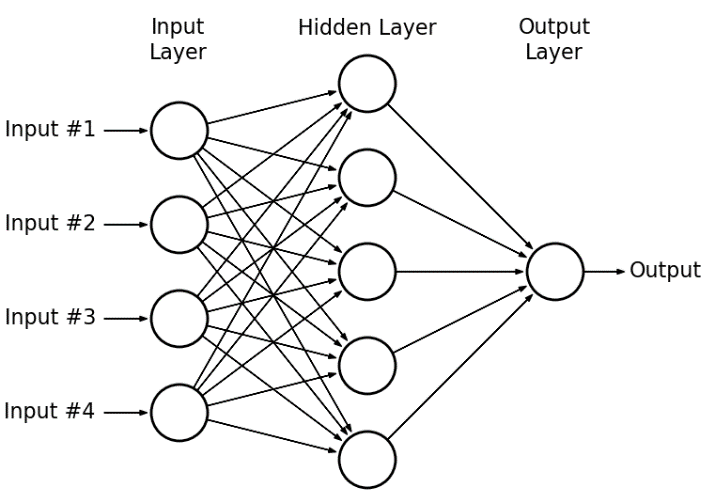

## ¿Y como escribo yo esto en python? 
En el notebook anterior ya hemos hecho una introducción al trabajo con tensores de pytorch, aplicación de funciones y al cálculo automático de gradientes. En este documento vamos a construir nuestra primera red neuronal, pero seguiremos utilizando los mismos conceptos básicos que manejábamos en ese tutorial. 

### Preparación
Vamos a ir paso a paso. Lo primero que tenemos que hacer es importar pytorch y algunos módulos de la librería: 
* `torch.nn`: La librería de redes neuronales que utilizaremos para crear nuestro modelo.
* `torch.autograd`: En concreto el módulo Variable de esta librería que se encarga de manejar las operaciones de los tensores y sus gradientes, que son más complejos que los que vimos en la parte anterior.
* `torchvision.datasets`: El módulo que ayudará a cargar el conjunto de datos que vamos a utilizar y explicaremos más adelante.
* `torchvision.transforms`: Este módulo contiene una serie de funciones que nos ayudarán modificando el dataset.
* `torch.optim`: De aquí usaremos el optimizador para entrenar la red neuronal y modificar sus pesos.

Para ello ejecutamos el siguiente código:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim

### Datos, datos, datos
Los datos son la parte más importante del *deep learning*, rivalizando con la arquitectura de red utilizada y cualquier otro parámetro. Para esta práctica-tutorial, vamos a utilizar el conjunto conocido como MNIST. Se trata de un conjunto de imágenes de dígitos escritos a mano, contiene un total de 60000 imágenes para entrenamiento y 10000 para *test*, o sea, para probar la efectividad de nuestro modelo. Todos los dígitos están normalizados en tamaño y centrados en la imagen de tamaño 28x28 en escala de grises. El objetivo de esta base de datos es clasificar cada imagen diciendo a que número entre el 0 y el 9 pertenece.

Para cargar de forma rápida el dataset vamos a utilizar el modulo `datasets` de `torchvision`, además debemos definir que transformaciones vamos a aplicarle a todas las muestras, como convertir el tipo de datos de la imagen a un `torch.Tensor`, el formato con el que esta librería puede realizar cálculos de forma eficiente. `torchvision.transforms` contiene una gran cantidad de transformaciones para aplicar a los datasets que quizá usemos más adelante, por ejemplo para normalizar el dataset, aunque dado que este dataset está normalizado a valores entre 0 y 1, no nos hará falta.

Definimos también en `root` el directorio donde guardamos los datos. Puede ser el que queráis, según el sistema operativo que estéis utilizando. Si juntamos la transformación (`transforms.ToTensor()`) y la guardamos en `trans`, podemos adjuntarla al cargador de los datos en `dset.MNIST` de la forma: 

In [ ]:
trans = transforms.Compose([transforms.ToTensor()]) #Transformador para el dataset
root = './data/'
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

El entrenamiento de una red neuronal se realiza mediante *batches*, o lo que es lo mismo, por subconjuntos de los datos de entrenamiento (de 2 en 2, de 5 en 5 o de 256 en 256...), lo que acelera el entrenamiento y hace que la red neuronal aprenda de forma más efeciva. Lo veremos más adelante. 

In [ ]:
batch_size = 128

Después definimos un `Dataloader` para el dataset que hemos descargado. Un `Dataloader`, que no es más que un objeto que, cuando lo llamemos con un comando determinado, nos dará las muestras de entrenamiento o test en grupos del tamaño `batch_size`. También contiene funciones que pueden ser útiles, como reordenar aleatoriamente el dataset en cada iteración (`shuffle`). El código será: 

In [ ]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

Podemos saber la cantidad de conjuntos (batches) de tamaño 128 tenemos simplemente utilizando la función `len` de Python. En el caso de que el dataset no sea un múltiplo del tamaño de batch, el último batch será de un tamaño reducido.

In [ ]:
print ('Trainning batch number: {}'.format(len(train_loader)))
print ('Testing batch number: {}'.format(len(test_loader)))

Y podemos mostrarlo utilizando la librería `matplotlib`, y la función `plt.imshow`, que muestra una imagen, así como la función `make_grid` de `torchvision`. 

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    plt.imshow(img.permute(1, 2, 0)) 
    # cambiamos las dimensiones para que el número de canales 
    # se muestre al final (por defecto en matplotlib)

# convertimos train_loader en un iterador
dataiter = iter(train_loader) 
# y recuperamos el i-esimo elemento, un par de valores (imagenes, etiquetas)
images, labels = dataiter.next() 

# Usamos la función imshow que hemos definido para mostrar imágenes
imshow(make_grid(images))

## Creación del modelo
Una vez tenemos el dataset debemos decidir que topología de red neuronal vamos a utilizar. Nosotros vamos a utilizar una red muy simple con una sola capa oculta con 256 neuronas. 

En PyTorch, las redes se definen como una clase que hereda de `nn.Module`. Si no sabéis que es una clase o un objeto, éste es un buen video de [introducción a la programación orientada a objetos](https://www.youtube.com/watch?v=tTPeP5dVuA4) en youtube. 

Las clases en python se definen con la palabra clave `class`, y para una red del tipo `nn.Module` debemos definir dos métodos fundamentales: `__init__` y `forward`. En `__init__` se definen que capas va a tener la red: 
* La primera capa será nuestra capa oculta que recibe un tamaño de entrada de 28x28 y una salida de 256 neuronas. 
* La segunda capa será la capa de salida, y recibirá las 256 salidas de la capa oculta y tendrá 10 neuronas de salida. 
Ambas capas serán de tipo `nn.Linear`, que es el tipo básico de operación que hemos descrito con la ecuación anterior.  

A continuación, se define la función `forward()`, que implementa las operaciones a realizar desde la entrada de la red a la salida. En nuestro caso, los pasos serán: 
* Linealizar las imágenes, es decir, transformarlas en un vector de 784 elementos, ya que un perceptrón requiere un vector de entrada. Esto lo hacemos con la función `view()`.
* Después aplicamos la capa 1 (`self.fc1`) y a su salida, la función de activación `F.relu()`.
* Finalmente aplicamos la capa 2 (`self.fc2`) y a su salida, la función de activación `F.softmax()`.

ReLU es la función [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) y la función [softmax](https://en.wikipedia.org/wiki/Softmax_function), que es una función que toma como entrada un vector de K números reales, y lo normaliza en una distribución de probabilidad consistente en K probabilidades proporcionales a los exponenciales de los números de entrada. Esta última nos dará las probabilidades de pertenencia de cada entrada a cada una de las 10 clases, y cogeremos como "etiqueta" aquella que tenga máxima probabilidad. 

El código para esta clase es: 

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)#capa oculta
        self.fc2 = nn.Linear(256, 10)#capa de salida
        
    def forward(self, x):
        x = x.view(-1, 28*28)#transforma las imágenes de tamaño (n, 28, 28) a (n, 784)
        x = F.relu(self.fc1(x))#Función de activación relu en la salida de la capa oculta
        x = F.softmax(self.fc2(x), dim=1)#Función de activación softmax en la salida de la capa oculta
        return x

A continuación definimos el criterio de *loss* y el optimizador. Como criterio de *loss* vamos a utilizar la entropía cruzada, una medida basada en la entropía que viene de la teoría de la información, y que calcula la diferencia entre dos distribuciones de probabilidad. Si recordáis, al usar "softmax" en la salida de la red nos da la probabilidad de cada neurona según la entrada. Si la comparamos a la distribución real (las etiquetas), nos dará una buena estimación del error. 

En cuanto al optimizador, utilizaremos el [descenso de gradiente estocástico](https://medium.com/metadatos/todo-lo-que-necesitas-saber-sobre-el-descenso-del-gradiente-aplicado-a-redes-neuronales-19bdbb706a78), una técnica de aprendizaje que se basa en el gradiente de la salida con respecto a la referencia, y actualiza los pesos de la red neuronal ajustándolos a dicho gradiente. Para ello es necesario crear el objeto `model`, nuestro modelo, a partir de la clase `MLP()` que hemos definido, y posteriormente pasar sus parámetros al optimizador: 

In [ ]:
model = MLP()
criterion = nn.CrossEntropyLoss() # definimos la pérdida
# y utilizamos descenso de gradiente estocástico con un learning-rate 
# (factor que cuantifica cuánto vamos a actualizar los pesos con respecto
# a su valor actual) de 0.01 y un momento de 0.9, que actualiza el learning
# rate en función de sus valores anteriores
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Entrenar el modelo
Ya tenemos nuestro modelo, con su arquitectura, loss y optimizador creados. Podemos empezar a entrenar el modelo. Esto se realiza mediante diversas iteraciones de entrenamiento, conocidas como **epoch**. La idea es básicamente hacer algo como (en pseudocódigo): 
```
for e in epochs: 
    for (images,labels) in dataset:
        salida = model(images) # conocido como "forward pass"
        loss = criterio(salida, labels)
        propagar gradiente de loss a todas las neuronas, conocido como "backward pass"
        optimizar usando dicho gradiente
```

In [ ]:
n_epochs = 20

for epoch in range(n_epochs):
    print("Train") # Esta será la parte de entrenamiento
    running_loss = 0.0 # el loss en cada epoch de entrenamiento
    running_acc = 0.0 # el accuracy de cada epoch
    total = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        total += labels.shape[0]
        # ponemos a cero todos los gradientes en todas las neuronas
        optimizer.zero_grad()

        # forward + backward + optimizar
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Mostramos las estadísticas
        running_loss += loss.item() # acumulamos el loss de este batch
        # extraemos las etiquetas que predice (nº neurona con máxima probabilidad)
        _, predicted = torch.max(outputs, 1) 
        running_acc += torch.sum(predicted==labels) # y acumulamos el número de correctos
    print(f'>>> Epoch {epoch} >>>> Loss: {running_loss/total}, Acc: {running_acc/total}')

Y al parecer, obtenemos un accuracy alto, de más del 90%. Eso quiere decir que acumula más del 90% de predicciones correctas a partir de los datos. Pero por supuesto, esto es en el conjunto del training. 

Sin embargo, para poder ver el poder predictivo de nuestro modelo entrenado, es importante probar su precisión en datos que dicho modelo no ha visto nunca. Y para eso es para lo que sirve el conjunto de test. 

### Test del modelo
En el test, en lugar del forward y el backward pass, solo vamos a utilizar el forward. Se le pasa el conjunto de test, se obtienen las predicciones y se comparan con las etiquetas reales para estimar la precisión en el test. 

Es importante deshabilitar la propagación del gradiente durante el foward pass, para que no modifiquemos los pesos de la red durante el test, y no contamine el entrenamiento. Así pues, con estas restricciones, el test se queda: 

In [ ]:
correct = 0
total = 0
with torch.no_grad(): # hay que deshabilitar la propagación de gradiente
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels).item()

print(f'Precisión del modelo en las imágenes de test: {correct / total}')

Vemos que en test alcanzamos un valor de 93% de precisión, muy similar a la precisión de training, lo cual significa que nuestro modelo será muy bueno para la detección de dígitos escritos a mano. 

La pregunta es... ¿podríamos mejorar esta precisión con otra arquitectura optimizada para imágenes? Lo veremos en la siguiente parte de la práctica, el notebook `02 Práctica Deep Learning - Redes Convolucionales.ipynb`. 